<a href="https://colab.research.google.com/github/zia207/python-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-11-tree-based-models-bagging-grf-boosted-regression-forest-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 2.8.11 Boosted Regression Forest

A **Boosted Regression Forest**, as implemented in the `{grf}` package in R, is a specialized extension of the random forest framework that combines **boosting** with random forests to improve predictive performance for regression tasks. Unlike standard random forests, which build independent trees and average their predictions, boosted regression forests incorporate a boosting mechanism to iteratively refine predictions by focusing on residuals or errors from previous iterations. This approach enhances accuracy, particularly for complex datasets with non-linear relationships. Below, I’ll explain the concept, its implementation in `{grf}`, and how it differs from other regression forest variants.



## Overview

A Boosted Regression Forest is a hybrid model that integrates the principles of **gradient boosting** with the random forest framework. It builds a sequence of regression forests where each subsequent forest focuses on correcting the errors (residuals) of the previous forests, similar to how gradient boosting works in models like XGBoost or LightGBM. In `{grf}`, this is implemented via the `boosted_regression_forest()` function, which is designed to predict continuous outcomes with improved accuracy by leveraging boosting to reduce bias while maintaining the robustness of random forests.



### Key features


- `Sequential Learning`: Trees or forests are built sequentially, with each iteration fitting to the residuals of the previous predictions.
- `Random Forest Structure`: Each iteration uses a random forest (with random feature selection and bootstrapping) to ensure robustness and prevent overfitting.
- `Honest Splitting`: Like other `{grf}` models, it supports honest splitting to reduce bias by separating data for tree structure and leaf estimation.
- `Regularization`: Includes parameters to control the boosting process, such as the number of boosting iterations and shrinkage (learning rate).

### How Boosted Regression Forests Work in `{grf}`

The `boosted_regression_forest()` function in `{grf}` operates as follows:

1. Input Data

   - A feature matrix $X$ (predictors) and a vector $Y$` (continuous outcome).
   - Parameters like `num.trees` (total trees across iterations), `num.trees.per.iter` (trees per boosting iteration), `lambda.reg` (regularization penalty), and `honesty` (for unbiased estimation).

2. Boosting Process

   - `Initialization`: Start with an initial prediction (e.g., the mean of $Y$ or a simple random forest).
   - `Iterative Updates`:
     - Compute residuals (differences between observed `Y` and current predictions).
     - Fit a new random forest to the residuals, using a subset of features and data (with random sampling, as in standard random forests).
     - Update predictions by adding a scaled version of the new forest’s predictions (controlled by a shrinkage factor or learning rate).
   - Repeat for a specified number of boosting iterations (`num.trees / num.trees.per.iter`).
   - If `honesty = TRUE`, each forest uses separate data for splits and leaf estimates to reduce bias.

3. Prediction

   - For a new data point, the final prediction is the sum of the initial prediction and the contributions from each boosted forest, adjusted by the shrinkage factor.
   - The result is a refined prediction that corrects errors iteratively.

4. Output

   - Predictions for new data points.
   - Optional outputs like variable importance or variance estimates.



### Advantages of Boosted Regression Forests

1. `Improved Accuracy`: By iteratively correcting residuals, boosted regression forests reduce bias compared to standard random forests, often leading to better predictive performance.
2. `Robustness`: Inherits random forest’s strengths, such as handling high-dimensional data, non-linear relationships, and robustness to noise.
3. `Flexible Regularization`: Parameters like `lambda.reg` and the number of boosting iterations allow control over overfitting and model complexity.
4. `Honest Estimation`: Supports `{grf}`’s honest splitting, ensuring unbiased predictions, especially for small or noisy datasets.
5. `Versatility`: Suitable for regression tasks where standard random forests underperform due to high bias or complex patterns.

### Limitations

1. `Computational Cost`: The sequential nature of boosting makes it slower than standard regression forests, especially with many iterations or large datasets.
2. `Overfitting Risk`: Without proper tuning (e.g., `lambda.reg`, number of iterations), boosting can overfit, especially on noisy data.
3. `Tuning Complexity`: Requires careful selection of parameters like `num.trees.per.iter`, `lambda.reg`, and shrinkage to balance bias and variance.
4. `Interpretability`: Like other random forests, interpreting the model is challenging, and the boosting component adds complexity.

### Applications

- `Economics`: Predicting outcomes like housing prices or income, where complex patterns require bias reduction.
- `Finance`: Forecasting stock returns or risk metrics with non-linear dependencies.
- `Environmental Science`: Modeling continuous outcomes like temperature or pollution levels with intricate feature interactions.
- `Any Regression Task`: Where standard random forests have high bias or where iterative refinement can improve accuracy.

### Key Differences from Other `{grf}` Models

| **Aspect**                     | **Standard Regression Forest** (`regression_forest`) | **Local Linear Forest** (`ll_regression_forest`) | **Boosted Regression Forest** (`boosted_regression_forest`) |
|--------------------------------|----------------------------------------------------|-----------------------------------------------|-----------------------------------------------------------|
| `Prediction Method`          | Averages outcomes in leaves.                       | Local linear regression using forest weights. | Iterative boosting of forests to fit residuals.           |
| `Learning Approach`          | Parallel (independent trees).                      | Parallel with local linear correction.        | Sequential (boosting iterations).                        |
| `Bias Reduction`             | Relies on averaging and honesty.                   | Local linear fits for smoother predictions.   | Boosting reduces bias by focusing on residuals.          |
| `Smoothness`                 | Piecewise constant.                                | Smooth predictions.                           | Piecewise constant but refined via boosting.             |
| `Use Case`                   | General regression tasks.                          | Smooth relationships.                         | Complex datasets needing bias reduction.                 |
| `Computational Cost`         | Moderate.                                          | Higher (due to local linear fits).            | Higher (due to sequential boosting).                    |
| `Regularization`             | Minimal (node size, tree depth).                   | Ridge penalty (`ll.lambda`).                  | Shrinkage and `lambda.reg` for boosting.                 |





## Boosted Regression Forest with Python

There is no standard optimized Python package like {scikit-learn} for LBoosted Regression Forest. Below, a Python implementation of boosted regression forest has adapted with a custopm function, `boosted_regression_forest()`.  We will use the Boston Housing dataset to predict median housing prices based on various features. The steps include data preparation, model fitting, prediction, and evaluation of performance metrics like RMSE and R-squared.


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Load and Prepare the Dataset


In [2]:
from sklearn.datasets import fetch_openml

# Load and prepare Boston Housing data (from your code)
boston = fetch_openml(name='boston', version=1, as_frame=True)
boston_df = boston.frame

# Split data into training (70%) and test (30%) sets
train_data, test_data = train_test_split(boston_df, test_size=0.3, random_state=123)

# Prepare features (X) and target (Y) as pandas DataFrames
X_train = train_data.drop('MEDV', axis=1)
Y_train = train_data['MEDV']
X_test = test_data.drop('MEDV', axis=1)
Y_test = test_data['MEDV']

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (354, 13)
Test data shape: (152, 13)


### Custom Function Boosted Regression Forest Model

**Boosted Regression Forest Function** is a custom implementation that combines gradient boosting with random forest principles. This code has two parts:

1.  `boosted_regression_forest`: This function implements a custom version of a Boosted Regression Forest. It trains an ensemble of decision trees sequentially. In each iteration, a new tree is trained to predict the residuals (the difference between the actual target values and the current predictions) of the previous trees. The predictions of this new tree are then scaled by a `learning_rate` and added to the current predictions. The function also includes options for subsampling the data and implementing "honesty" (though honesty is disabled in the subsequent cell). Feature importances are also calculated based on the contribution of each feature across all trees.

2.  `predict_brf`: This function takes the trained boosted regression forest model (the output of `boosted_regression_forest`) and a set of new features `X`, and generates predictions. It starts with the initial prediction (the mean of the training target variable) and then iteratively adds the predictions from each tree in the forest, scaled by the learning rate.

In essence, this code defines a custom boosting algorithm where individual decision trees are the base learners, and they are trained on the errors of the combined ensemble in an iterative manner.

In [3]:
# Set random seed for reproducibility
np.random.seed(123)

def boosted_regression_forest(X, y, num_trees=500, learning_rate=0.1, 
                             max_depth=3, min_samples_split=2, 
                             min_samples_leaf=5, honesty=True, 
                             subsample=0.8, verbose=False):
    """
    Corrected Boosted Regression Forest implementation
    """
    
    # Store feature names before converting to numpy array
    if hasattr(X, 'columns'):
        feature_names = X.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X.shape[1])]
    
    X = np.array(X)
    y = np.array(y)
    n_samples = X.shape[0]
    
    # Initialize predictions with mean of y
    current_predictions = np.full(n_samples, np.mean(y))
    trees = []
    feature_importances = np.zeros(X.shape[1])
    
    for i in range(num_trees):
        if verbose and i % 100 == 0:
            print(f"Training tree {i+1}/{num_trees}")
        
        # Calculate residuals (negative gradient)
        residuals = y - current_predictions
        
        # Subsample data
        if subsample < 1.0:
            sample_indices = np.random.choice(n_samples, size=int(n_samples * subsample), replace=False)
            X_sampled = X[sample_indices]
            residuals_sampled = residuals[sample_indices]
        else:
            X_sampled = X
            residuals_sampled = residuals
        
        # Split for honesty if enabled
        if honesty:
            split_indices = np.random.choice(len(X_sampled), size=len(X_sampled)//2, replace=False)
            X_tree = X_sampled[split_indices]
            y_tree = residuals_sampled[split_indices]
        else:
            X_tree = X_sampled
            y_tree = residuals_sampled
        
        # Train decision tree on residuals
        tree = DecisionTreeRegressor(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=123 + i
        )
        tree.fit(X_tree, y_tree)
        
        # Update feature importance
        feature_importances += tree.feature_importances_
        
        # Update predictions
        tree_preds = tree.predict(X)
        current_predictions += learning_rate * tree_preds
        
        trees.append(tree)
    
    # Normalize feature importance
    feature_importances /= num_trees
    
    model = {
        'trees': trees,
        'learning_rate': learning_rate,
        'initial_prediction': np.mean(y),
        'feature_importances': feature_importances,
        'feature_names': feature_names  # Use the stored feature names
    }
    
    return model

def predict_brf(model, X):
    """
    Make predictions using the boosted regression forest model
    """
    X = np.array(X)
    predictions = np.full(X.shape[0], model['initial_prediction'])
    
    for tree in model['trees']:
        predictions += model['learning_rate'] * tree.predict(X)
    
    return predictions

### Fit Boosted Regression Forest Model

Boosted regression forests are particularly useful for regression tasks where complex relationships exist between features and the target variable. In this example, we will fit a boosted regression forest model to predict median housing prices (`medv`) based on various features in the Boston Housing dataset.

In [4]:
# Train the boosted regression forest model
print("Training Boosted Regression Forest...")
brf_model = boosted_regression_forest(X_train, Y_train, 
                                     num_trees=200,  # Reduced for better performance
                                     learning_rate=0.05,  # Smaller learning rate
                                     min_samples_leaf=5,  # Regularization
                                     honesty=False,  # Disable honesty for now
                                     verbose=True)

Training Boosted Regression Forest...
Training tree 1/200
Training tree 101/200


### Predict on Test Set and Evaluate Model

In [5]:
# Predict on Test Set
print("\nMaking predictions on test set...")
Y_pred = predict_brf(brf_model, X_test)

# Evaluate Model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_pred)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Making predictions on test set...

Model Performance:
MSE: 14.2034
RMSE: 3.7687
R²: 0.8243


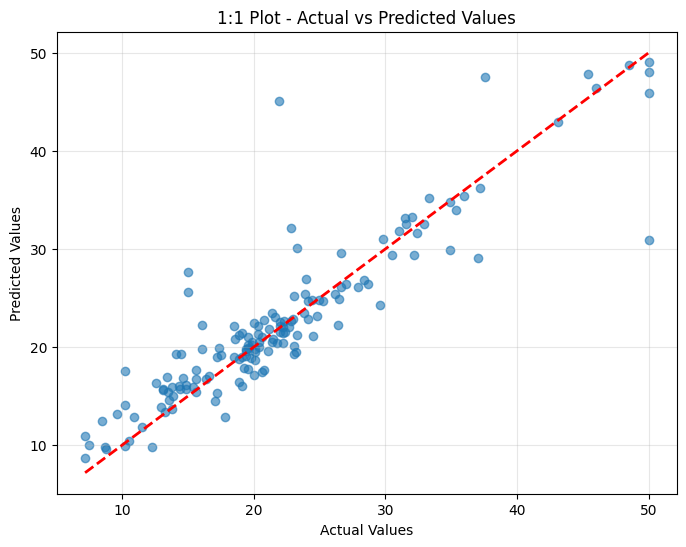

In [6]:
# Visualize Predictions
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, alpha=0.6)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('1:1 Plot - Actual vs Predicted Values')
plt.grid(True, alpha=0.3)
plt.show()

### Feature Importance

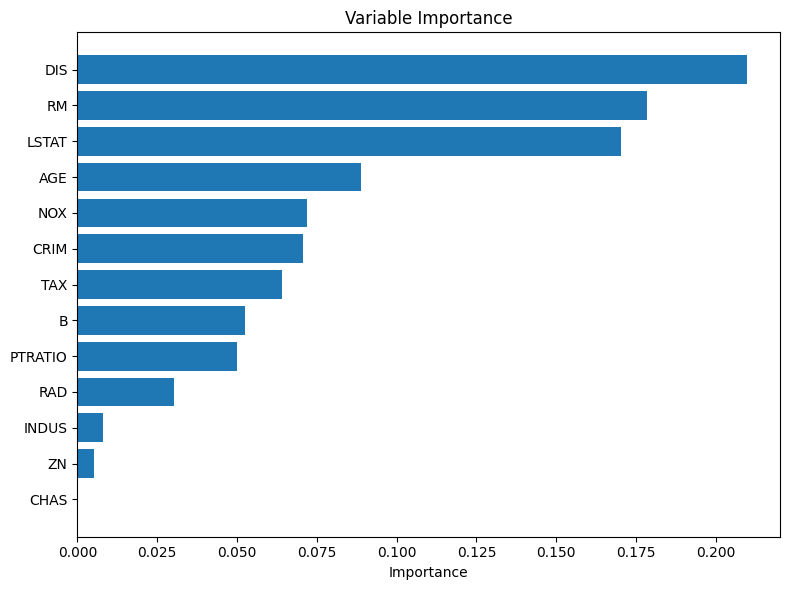


Variable Importance:
feature  importance
    DIS    0.209607
     RM    0.178296
  LSTAT    0.170302
    AGE    0.088848
    NOX    0.071977
   CRIM    0.070743
    TAX    0.064163
      B    0.052635
PTRATIO    0.049950
    RAD    0.030153
  INDUS    0.008093
     ZN    0.005232
   CHAS    0.000000


In [7]:
if brf_model['feature_names']:
    importance_df = pd.DataFrame({
        'feature': brf_model['feature_names'],
        'importance': brf_model['feature_importances']
    })
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    plt.figure(figsize=(8, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Importance')
    plt.title('Variable Importance')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("\nVariable Importance:")
    print(importance_df.to_string(index=False))

## Summary and Conclusion

This notebook provides a comprehensive overview and practical implementation of Boosted Regression Forests using custom function `boosted_regression_forest` in Python. The notebook starts by explaining the theoretical foundation of Boosted Regression Forests, highlighting their sequential learning approach to correct residuals from previous iterations. It emphasizes key features such as sequential learning, random forest structure, honest splitting, and regularization. The mechanism of how `boosted_regression_forest()` works is detailed, outlining the boosting process from initialization to iterative updates and final prediction.

The advantages and limitations of Boosted Regression Forests are discussed, including improved accuracy, robustness, flexible regularization, and honest estimation as advantages, while computational cost, overfitting risk, tuning complexity, and interpretability are noted as limitations. Potential applications in various fields like economics, finance, and environmental science are also presented. A table clearly differentiates Boosted Regression Forests from Standard Regression Forests and Local Linear Forests within the `{grf}` framework.


The core of the practical demonstration involves fitting the `boosted_regression_forest` model using the prepared training data and predicting on the test set. The performance of the model is evaluated using Root Mean Squared Error (RMSE) and R-squared metrics, which are then printed. Finally, a scatter plot is generated to visualize the predicted versus observed median housing prices on the test set, providing a visual assessment of the model's performance.

In conclusion, this notebook successfully illustrates the concept and application of Boosted Regression Forests. It demonstrates how this advanced ensemble technique can be used for regression tasks in a Python environment, showcasing its potential for improved predictive accuracy compared to traditional methods. The provided code and explanations serve as a valuable resource for understanding and implementing Boosted Regression Forests for similar regression problems.


## References

1. [Boosted regression forest](https://grf-labs.github.io/grf/reference/boosted_regression_forest.html)

